In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from scipy import stats
import math
from wrangle_zillow import acquire_zillow
from wrangle_zillow import missing_col_values
from wrangle_zillow import missing_row_values
from wrangle_zillow import single_unit_properties
from wrangle_zillow import data_prep
from wrangle_zillow import split_data
from wrangle_zillow import remove_outliers
from wrangle_zillow import split_by_region
from wrangle_zillow import lr_model_prep
from wrangle_zillow import cluster_model_prep


from sklearn.linear_model import TweedieRegressor

In [2]:
df = acquire_zillow()
df.head()

Reading from csv file...


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df = single_unit_properties(df)
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)


In [4]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((28544, 30), (12234, 30), (10195, 30))

In [5]:
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
train = remove_outliers(train, 1.5, out_columns)

In [8]:
scale_cols = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
scaler = MinMaxScaler()
scaler.fit(scale_cols)
scaled_df = scaler.transform(scale_cols)
scaled_cols_df = pd.DataFrame(scaled_df, columns=scale_cols.columns, index=scale_cols.index)

In [6]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
57956,2335449,12844928,3.0,4.0,3.0,2650.0,2650.0,6037.0,3.0,33982542.0,...,1987.0,413700.0,793000.0,2016.0,379300.0,9646.34,6.037409e+13,0.026122,2017-05-26,Single Family Residential
73971,244642,12075460,3.0,3.0,3.0,3094.0,3094.0,6037.0,3.0,34187250.0,...,1949.0,133565.0,231922.0,2016.0,98357.0,3221.28,6.037461e+13,-0.030712,2017-05-31,Single Family Residential
8195,877004,14282224,2.0,3.0,2.0,1647.0,1647.0,6059.0,2.0,33639152.0,...,1958.0,79671.0,1092488.0,2016.0,1012817.0,12046.64,6.059063e+13,-0.013707,2017-08-07,Single Family Residential
7355,2249559,14393950,1.5,3.0,1.5,1174.0,1174.0,6059.0,1.0,33572200.0,...,1982.0,93580.0,366000.0,2016.0,272420.0,3744.58,6.059042e+13,0.028213,2017-05-24,Single Family Residential
58226,1156183,12514614,3.0,3.0,3.0,1742.0,1742.0,6037.0,3.0,33794806.0,...,1949.0,164991.0,525213.0,2016.0,360222.0,6283.46,6.037574e+13,-0.002124,2017-06-22,Single Family Residential


In [9]:
scaled_cols_df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude
57956,0.666667,0.666667,0.740807,0.435923,0.804810
73971,0.666667,0.333333,0.872479,0.575069,0.652562
8195,0.333333,0.333333,0.443357,0.202511,0.816555
7355,0.166667,0.333333,0.303084,0.157001,0.924487
58226,0.666667,0.333333,0.471530,0.308313,0.695515


---

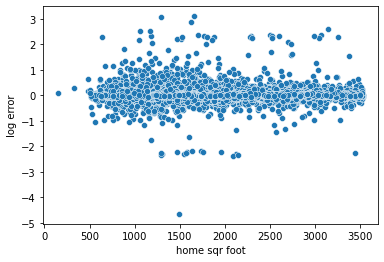

In [11]:
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror", data=train)
plt.xlabel("home sqr foot")
plt.ylabel("log error")
plt.show()

In [12]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.calculatedfinishedsquarefeet
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.01345112500446546 P-Value = 0.029782946539496435
-----------------------------------
We reject the null hypothesis


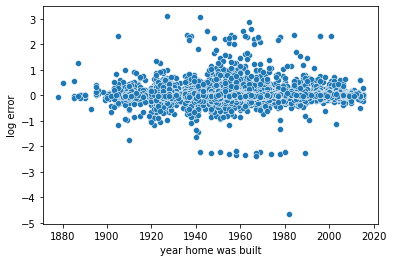

In [13]:
sns.scatterplot(x="yearbuilt", y="logerror", data=train)
plt.xlabel("year home was built")
plt.ylabel("log error")
plt.show()

In [14]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.yearbuilt
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.009893873297234986 P-Value = 0.10998182422514384
-----------------------------------
We do not reject the null hypothesis


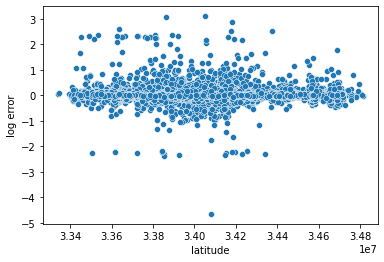

In [16]:
sns.scatterplot(x="latitude", y="logerror", data=train)
plt.xlabel("latitude")
plt.ylabel("log error")
plt.show()

In [17]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.latitude
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = -0.016678118482840593 P-Value = 0.007052903217613151
-----------------------------------
We reject the null hypothesis


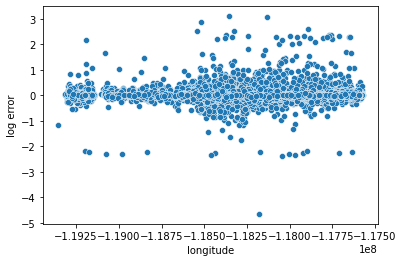

In [18]:
sns.scatterplot(x="longitude", y="logerror", data=train)
plt.xlabel("longitude")
plt.ylabel("log error")
plt.show()

In [19]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.longitude
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.022473512518182796 P-Value = 0.00028256268153665446
-----------------------------------
We reject the null hypothesis


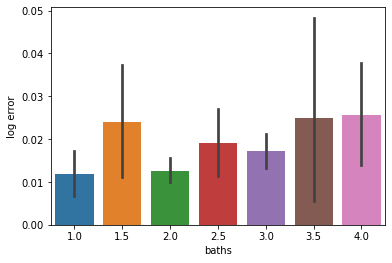

In [20]:
sns.barplot(x="bathroomcnt", y="logerror", data=train)
plt.xlabel("baths")
plt.ylabel("log error")
plt.show()

In [21]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.bathroomcnt
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.015931904262757063 P-Value = 0.010059711283207814
-----------------------------------
We reject the null hypothesis


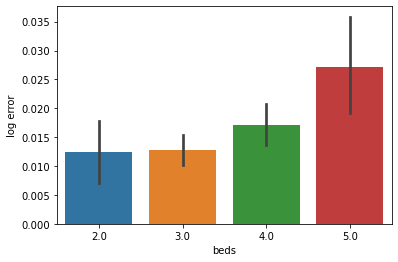

In [22]:
sns.barplot(x="bedroomcnt", y="logerror", data=train)
plt.xlabel("beds")
plt.ylabel("log error")
plt.show()

In [23]:
#assign an alpha value
alpha = 0.05
#assign the x and y variables from the train dataset
x = train.bedroomcnt
y = train.logerror
#run a pearson r correlation test
corr, p = stats.pearsonr(x, y)
#output the results of the test
print(f'Correlation Coefficient = {corr} P-Value = {p}')
print('-----------------------------------')
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We do not reject the null hypothesis')

Correlation Coefficient = 0.0182726424149222 P-Value = 0.0031575247715086353
-----------------------------------
We reject the null hypothesis


---

# restart kernel

In [3]:
df = acquire_zillow()
df = single_unit_properties(df)
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)
df1, df2, df3 = split_by_region(df)
df1['dist_lat'] = df1.latitude - 34012355
df1['dist_long'] = df1.longitude - (-118498665)
df2['dist_lat'] = df2.latitude - 33640954
df2['dist_long'] = df2.longitude - (-117978893)
df3['dist_lat'] = df3.latitude - 34267111
df3['dist_long'] = df3.longitude - (-119278788)

Reading from csv file...


---

# DF1

In [8]:
train1, validate1, test1 = split_data(df1)
#out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#train1 = remove_outliers(train1, 1.5, out_columns)
#scale_cols1 = train1[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'dist_lat', 'dist_long']]
#scaler = MinMaxScaler()
#scaler.fit(scale_cols1)
#scaled_df1 = scaler.transform(scale_cols1)
#scaled_cols_df1 = pd.DataFrame(scaled_df1, columns=scale_cols1.columns, index=scale_cols1.index)
cluster_df1_train = cluster_model_prep(train1)
cluster_df1_val = cluster_model_prep(validate1)
cluster_df1_test = cluster_model_prep(test1)



In [7]:
cluster_df1_train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,dist_lat,dist_long
54251,0.000000,0.333333,0.288449,0.393231,0.672171,0.393231,0.672171
66483,0.333333,0.333333,0.561264,0.546168,0.374471,0.546168,0.374471
8143,0.666667,1.000000,0.782068,0.867092,0.565272,0.867092,0.565272
40171,0.333333,0.333333,0.391193,0.322409,0.666569,0.322409,0.666569
37135,0.333333,0.000000,0.291640,0.554581,0.427608,0.554581,0.427608


In [9]:
cluster_df1_val.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,dist_lat,dist_long
55152,0.333333,0.666667,0.985823,0.905581,0.556918,0.905581,0.556918
62488,0.000000,0.000000,0.269357,0.424489,0.683105,0.424489,0.683105
75790,0.000000,0.333333,0.244275,0.354504,0.586822,0.354504,0.586822
15812,0.666667,0.333333,0.649945,0.438751,0.407906,0.438751,0.407906
59554,0.333333,0.333333,0.377681,0.288110,0.360715,0.288110,0.360715


In [10]:
cluster_df1_test.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,dist_lat,dist_long
69956,0.000000,0.333333,0.196409,0.136335,0.602411,0.136335,0.602411
68506,0.000000,0.000000,0.146574,0.193634,0.547702,0.193634,0.547702
32953,0.333333,0.333333,0.239648,0.774033,0.784059,0.774033,0.784059
20469,0.000000,0.333333,0.212532,0.170451,0.507985,0.170451,0.507985
781,0.666667,0.333333,0.576768,0.412482,0.412612,0.412482,0.412612


In [4]:
train1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long
54251,560506,12724517,1.0,3.0,1.0,1056.0,1056.0,6037.0,1.0,33919508.0,...,327119.0,2016.0,169448.0,4465.70,6.037550e+13,0.022905,2017-08-17,Single Family Residential,-92847.0,408770.0
66483,329959,10862352,2.0,3.0,2.0,1911.0,1911.0,6037.0,2.0,34144563.0,...,1064996.0,2016.0,851997.0,13018.79,6.037142e+13,-0.039135,2017-03-21,Single Family Residential,132208.0,52161.0
8143,2076185,11182996,3.0,5.0,3.0,2603.0,2603.0,6037.0,3.0,34616817.0,...,346231.0,2016.0,121851.0,5163.27,6.037910e+13,0.074580,2017-08-01,Single Family Residential,604462.0,280717.0
40171,529653,12439184,2.0,3.0,2.0,1378.0,1378.0,6037.0,2.0,33815291.0,...,615400.0,2016.0,462718.0,7384.35,6.037574e+13,-0.024070,2017-06-30,Single Family Residential,-197064.0,402059.0
37135,1045800,10900954,2.0,2.0,2.0,1066.0,1066.0,6037.0,2.0,34156942.0,...,626625.0,2016.0,484093.0,7527.80,6.037143e+13,0.174064,2017-04-27,Single Family Residential,144587.0,115813.0


In [5]:
scaled_cols_df1.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,dist_lat,dist_long
54251,0.000000,0.333333,0.288449,0.393231,0.672171,0.393231,0.672171
66483,0.333333,0.333333,0.561264,0.546168,0.374471,0.546168,0.374471
8143,0.666667,1.000000,0.782068,0.867092,0.565272,0.867092,0.565272
40171,0.333333,0.333333,0.391193,0.322409,0.666569,0.322409,0.666569
37135,0.333333,0.000000,0.291640,0.554581,0.427608,0.554581,0.427608


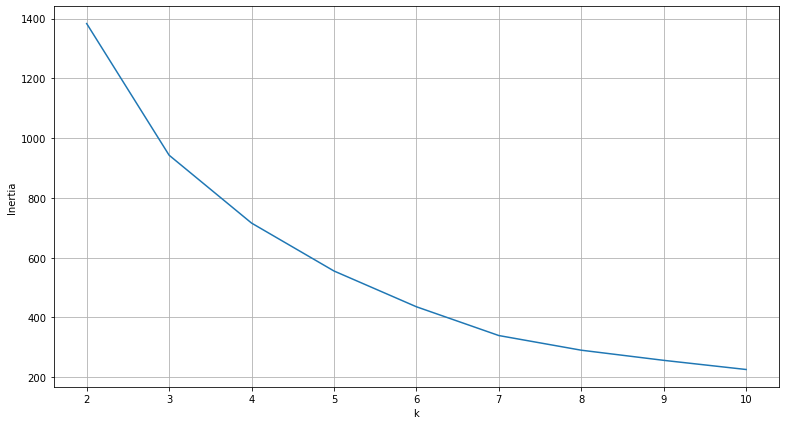

In [6]:
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']
x = scaled_cols_df1[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [7]:
x = scaled_cols_df1[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
train1['bedbathsqft_cluster'] = kmeans.predict(x)

In [8]:
train1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long,bedbathsqft_cluster
54251,560506,12724517,1.0,3.0,1.0,1056.0,1056.0,6037.0,1.0,33919508.0,...,2016.0,169448.0,4465.70,6.037550e+13,0.022905,2017-08-17,Single Family Residential,-92847.0,408770.0,1
66483,329959,10862352,2.0,3.0,2.0,1911.0,1911.0,6037.0,2.0,34144563.0,...,2016.0,851997.0,13018.79,6.037142e+13,-0.039135,2017-03-21,Single Family Residential,132208.0,52161.0,0
8143,2076185,11182996,3.0,5.0,3.0,2603.0,2603.0,6037.0,3.0,34616817.0,...,2016.0,121851.0,5163.27,6.037910e+13,0.074580,2017-08-01,Single Family Residential,604462.0,280717.0,2
40171,529653,12439184,2.0,3.0,2.0,1378.0,1378.0,6037.0,2.0,33815291.0,...,2016.0,462718.0,7384.35,6.037574e+13,-0.024070,2017-06-30,Single Family Residential,-197064.0,402059.0,0
37135,1045800,10900954,2.0,2.0,2.0,1066.0,1066.0,6037.0,2.0,34156942.0,...,2016.0,484093.0,7527.80,6.037143e+13,0.174064,2017-04-27,Single Family Residential,144587.0,115813.0,1


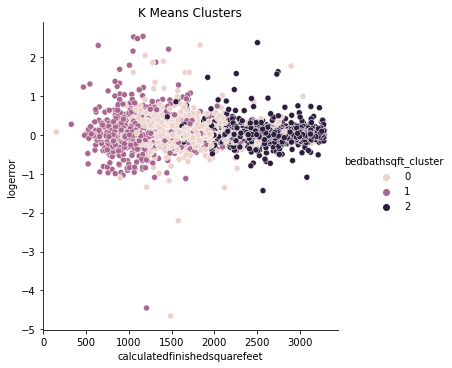

In [9]:
sns.relplot(data=train1, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')
plt.title('K Means Clusters')
plt.show()

In [10]:
clust_1 = train1[train1['bedbathsqft_cluster']== 0]
clust_2 = train1[train1['bedbathsqft_cluster']== 1]
clust_3 = train1[train1['bedbathsqft_cluster']== 2]
clust_1.logerror.mean(), clust_2.logerror.mean(), clust_3.logerror.mean()

(0.012245427364873072, 0.011631384360596693, 0.015963774955930522)

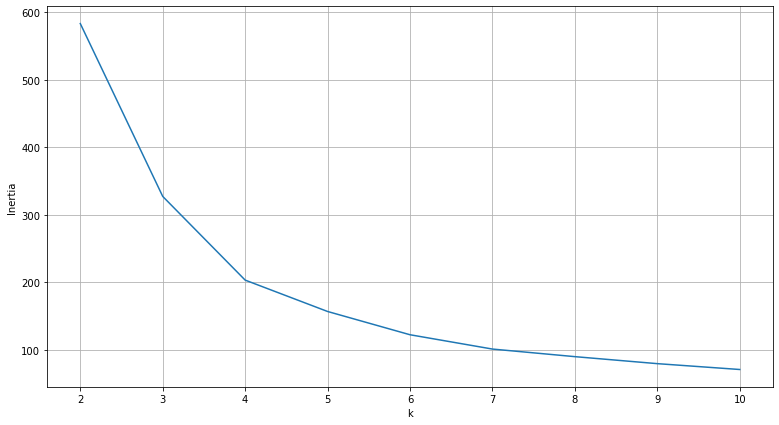

In [11]:
cols = ['latitude', 'longitude']
x = scaled_cols_df1[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [12]:
x = scaled_cols_df1[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train1['latlong_cluster'] = kmeans.predict(x)

In [13]:
train1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long,bedbathsqft_cluster,latlong_cluster
54251,560506,12724517,1.0,3.0,1.0,1056.0,1056.0,6037.0,1.0,33919508.0,...,169448.0,4465.70,6.037550e+13,0.022905,2017-08-17,Single Family Residential,-92847.0,408770.0,1,1
66483,329959,10862352,2.0,3.0,2.0,1911.0,1911.0,6037.0,2.0,34144563.0,...,851997.0,13018.79,6.037142e+13,-0.039135,2017-03-21,Single Family Residential,132208.0,52161.0,0,2
8143,2076185,11182996,3.0,5.0,3.0,2603.0,2603.0,6037.0,3.0,34616817.0,...,121851.0,5163.27,6.037910e+13,0.074580,2017-08-01,Single Family Residential,604462.0,280717.0,2,0
40171,529653,12439184,2.0,3.0,2.0,1378.0,1378.0,6037.0,2.0,33815291.0,...,462718.0,7384.35,6.037574e+13,-0.024070,2017-06-30,Single Family Residential,-197064.0,402059.0,0,1
37135,1045800,10900954,2.0,2.0,2.0,1066.0,1066.0,6037.0,2.0,34156942.0,...,484093.0,7527.80,6.037143e+13,0.174064,2017-04-27,Single Family Residential,144587.0,115813.0,1,2


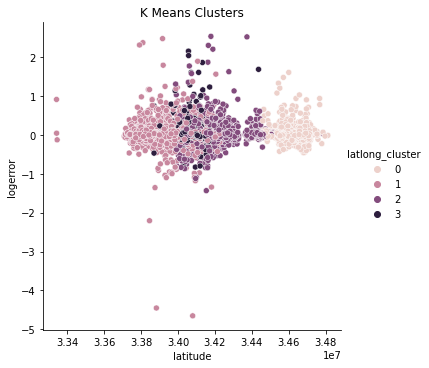

In [14]:
sns.relplot(data=train1, y='logerror', x='latitude', hue='latlong_cluster')
plt.title('K Means Clusters')
plt.show()

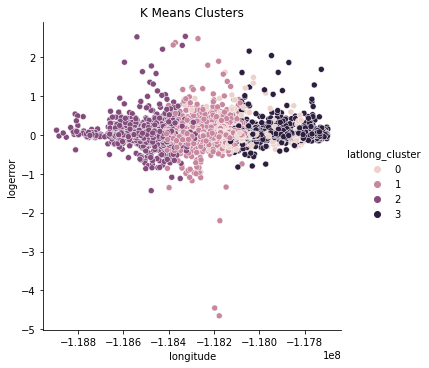

In [15]:
sns.relplot(data=train1, y='logerror', x='longitude', hue='latlong_cluster')
plt.title('K Means Clusters')
plt.show()

In [16]:
clust_1 = train1[train1['latlong_cluster']== 0]
clust_2 = train1[train1['latlong_cluster']== 1]
clust_3 = train1[train1['latlong_cluster']== 2]
clust_4 = train1[train1['latlong_cluster']== 3]

clust_1.logerror.mean(), clust_2.logerror.mean(), clust_3.logerror.mean(), clust_4.logerror.mean()

(0.015796326572379085,
 0.007643095771413721,
 0.012097874293148922,
 0.022667997893309817)

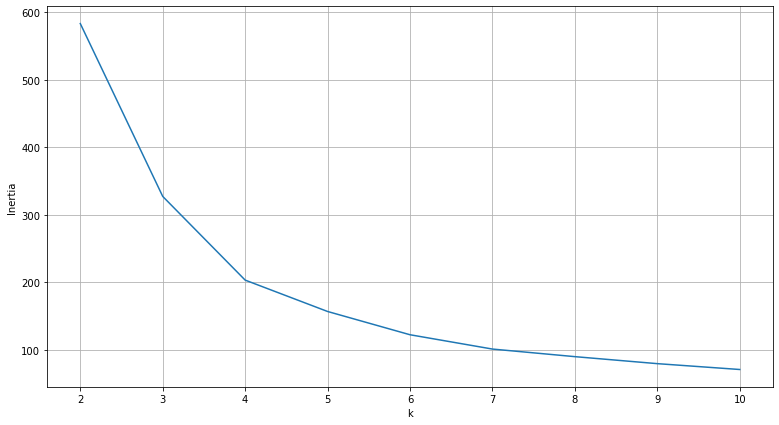

In [17]:
cols = ['dist_lat', 'dist_long']
x = scaled_cols_df1[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [18]:
x = scaled_cols_df1[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train1['dist_cluster'] = kmeans.predict(x)

In [19]:
train1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long,bedbathsqft_cluster,latlong_cluster,dist_cluster
54251,560506,12724517,1.0,3.0,1.0,1056.0,1056.0,6037.0,1.0,33919508.0,...,4465.70,6.037550e+13,0.022905,2017-08-17,Single Family Residential,-92847.0,408770.0,1,1,1
66483,329959,10862352,2.0,3.0,2.0,1911.0,1911.0,6037.0,2.0,34144563.0,...,13018.79,6.037142e+13,-0.039135,2017-03-21,Single Family Residential,132208.0,52161.0,0,2,2
8143,2076185,11182996,3.0,5.0,3.0,2603.0,2603.0,6037.0,3.0,34616817.0,...,5163.27,6.037910e+13,0.074580,2017-08-01,Single Family Residential,604462.0,280717.0,2,0,0
40171,529653,12439184,2.0,3.0,2.0,1378.0,1378.0,6037.0,2.0,33815291.0,...,7384.35,6.037574e+13,-0.024070,2017-06-30,Single Family Residential,-197064.0,402059.0,0,1,1
37135,1045800,10900954,2.0,2.0,2.0,1066.0,1066.0,6037.0,2.0,34156942.0,...,7527.80,6.037143e+13,0.174064,2017-04-27,Single Family Residential,144587.0,115813.0,1,2,2


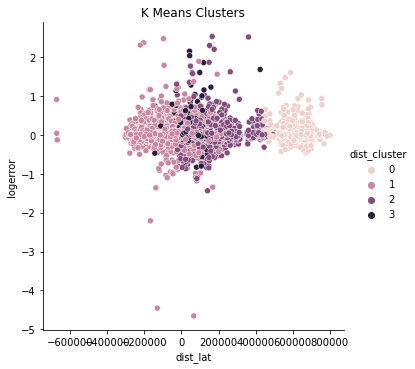

In [20]:
sns.relplot(data=train1, y='logerror', x='dist_lat', hue='dist_cluster')
plt.title('K Means Clusters')
plt.show()

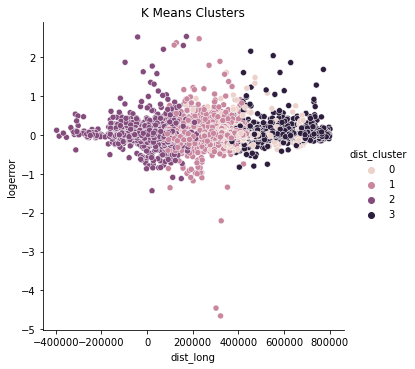

In [21]:
sns.relplot(data=train1, y='logerror', x='dist_long', hue='dist_cluster')
plt.title('K Means Clusters')
plt.show()

# DF2

In [ ]:
train2, validate2, test2 = split_data(df2)
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
train2 = remove_outliers(train2, 1.5, out_columns)
scale_cols2 = train2[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'dist_lat', 'dist_long']]
scaler = MinMaxScaler()
scaler.fit(scale_cols2)
scaled_df2 = scaler.transform(scale_cols2)
scaled_cols_df2 = pd.DataFrame(scaled_df2, columns=scale_cols2.columns, index=scale_cols2.index)



# DF3

In [ ]:
train3, validate3, test3 = split_data(df3)
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
train3 = remove_outliers(train3, 1.5, out_columns)
scale_cols3 = train3[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'dist_lat', 'dist_long']]
scaler = MinMaxScaler()
scaler.fit(scale_cols3)
scaled_df3 = scaler.transform(scale_cols3)
scaled_cols_df3 = pd.DataFrame(scaled_df3, columns=scale_cols3.columns, index=scale_cols3.index)



---

# Restart with all functions from .py

In [2]:
df = acquire_zillow()
df = single_unit_properties(df)
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)
df1, df2, df3 = split_by_region(df)
df1['dist_lat'] = df1.latitude - 34012355
df1['dist_long'] = df1.longitude - (-118498665)
df2['dist_lat'] = df2.latitude - 33640954
df2['dist_long'] = df2.longitude - (-117978893)
df3['dist_lat'] = df3.latitude - 34267111
df3['dist_long'] = df3.longitude - (-119278788)

Reading from csv file...


In [3]:
train1, validate1, test1 = split_data(df1)
train2, validate2, test2 = split_data(df2)
train3, validate3, test3 = split_data(df3)

out_cols = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
train1 = remove_outliers(train1, 1.5, out_cols)
train2 = remove_outliers(train2, 1.5, out_cols)
train3 = remove_outliers(train3, 1.5, out_cols)

cluster_df1_train = cluster_model_prep(train1)
cluster_df1_val = cluster_model_prep(validate1)
cluster_df1_test = cluster_model_prep(test1)

cluster_df2_train = cluster_model_prep(train2)
cluster_df2_val = cluster_model_prep(validate2)
cluster_df2_test = cluster_model_prep(test2)

cluster_df3_train = cluster_model_prep(train3)
cluster_df3_val = cluster_model_prep(validate3)
cluster_df3_test = cluster_model_prep(test3)

# Cluster 1 - bed, bath, sqft

In [4]:
#df1
x = cluster_df1_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
train1['bedbathsqft_cluster'] = kmeans.predict(x)

x = cluster_df1_val[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
validate1['bedbathsqft_cluster'] = kmeans.predict(x)

x = cluster_df1_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
test1['bedbathsqft_cluster'] = kmeans.predict(x)



#df2
x = cluster_df2_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
train2['bedbathsqft_cluster'] = kmeans.predict(x)

x = cluster_df2_val[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
validate2['bedbathsqft_cluster'] = kmeans.predict(x)

x = cluster_df2_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
test2['bedbathsqft_cluster'] = kmeans.predict(x)


#df3
x = cluster_df3_train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
train3['bedbathsqft_cluster'] = kmeans.predict(x)

x = cluster_df3_val[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
validate3['bedbathsqft_cluster'] = kmeans.predict(x)

x = cluster_df3_test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(x)
test3['bedbathsqft_cluster'] = kmeans.predict(x)







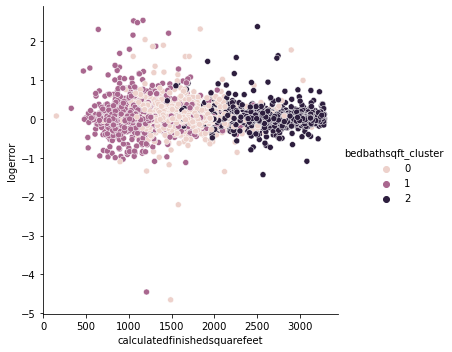

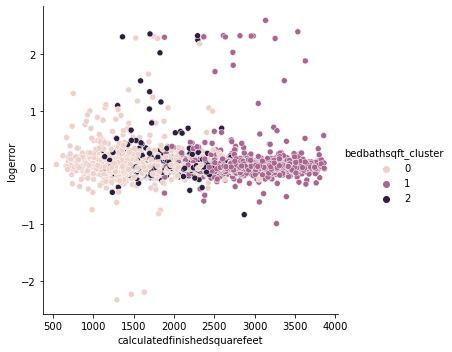

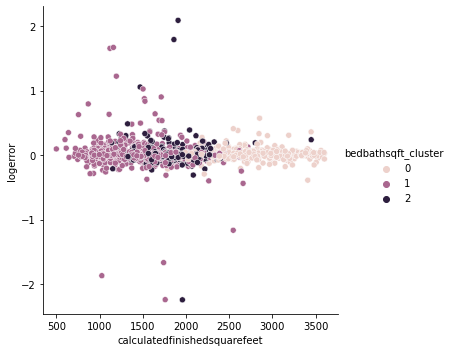

In [5]:

sns.relplot(data=train1, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')

sns.relplot(data=train2, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')

sns.relplot(data=train3, y='logerror', x='calculatedfinishedsquarefeet', hue='bedbathsqft_cluster')

plt.show()

In [6]:
clust_1 = train1[train1['bedbathsqft_cluster']== 0]
clust_2 = train1[train1['bedbathsqft_cluster']== 1]
clust_3 = train1[train1['bedbathsqft_cluster']== 2]
print('df1 log error means:')
print(clust_1.logerror.mean(), clust_2.logerror.mean(), clust_3.logerror.mean())

clust_4 = train2[train2['bedbathsqft_cluster']== 0]
clust_5 = train2[train2['bedbathsqft_cluster']== 1]
clust_6 = train2[train2['bedbathsqft_cluster']== 2]
print('df2 log error means:')
print(clust_4.logerror.mean(), clust_5.logerror.mean(), clust_6.logerror.mean())

clust_7 = train3[train3['bedbathsqft_cluster']== 0]
clust_8 = train3[train3['bedbathsqft_cluster']== 1]
clust_9 = train3[train3['bedbathsqft_cluster']== 2]
print('df3 log error means:')
print(clust_7.logerror.mean(), clust_8.logerror.mean(), clust_9.logerror.mean())


df1 log error means:
0.012245427364873072 0.011631384360596693 0.015963774955930522
df2 log error means:
0.022335034111095664 0.0347695345758422 0.027717877271435973
df3 log error means:
0.01035804241046321 0.012499964854866282 0.019048492539035507


# cluster 2 - lat/long

In [7]:
#df1
x = cluster_df1_train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train1['latlong_cluster'] = kmeans.predict(x)

x = cluster_df1_val[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate1['latlong_cluster'] = kmeans.predict(x)

x = cluster_df1_test[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test1['latlong_cluster'] = kmeans.predict(x)


#df2
x = cluster_df2_train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train2['latlong_cluster'] = kmeans.predict(x)

x = cluster_df2_val[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate2['latlong_cluster'] = kmeans.predict(x)

x = cluster_df2_test[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test2['latlong_cluster'] = kmeans.predict(x)


#df3
x = cluster_df3_train[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train3['latlong_cluster'] = kmeans.predict(x)

x = cluster_df3_val[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate3['latlong_cluster'] = kmeans.predict(x)

x = cluster_df3_test[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test3['latlong_cluster'] = kmeans.predict(x)

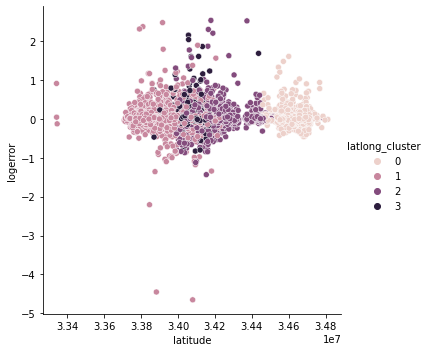

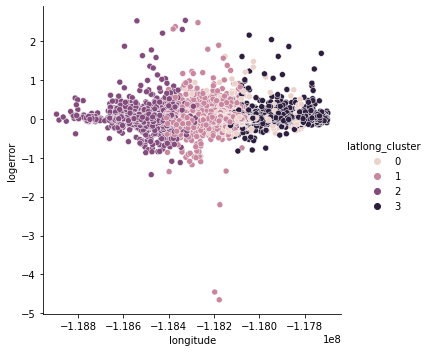

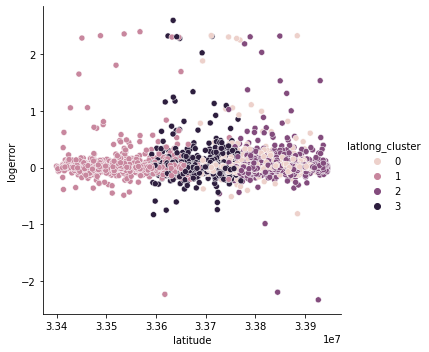

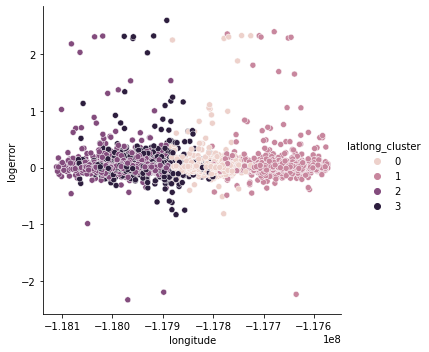

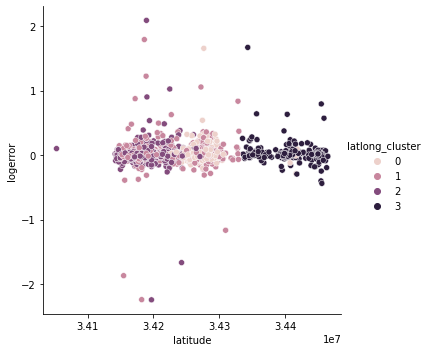

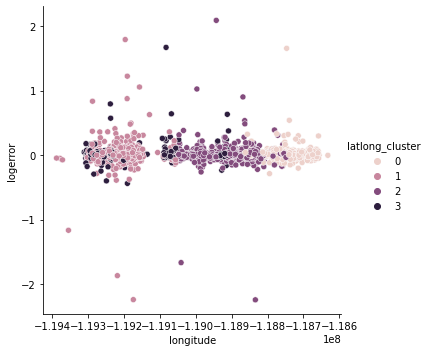

In [8]:
sns.relplot(data=train1, y='logerror', x='latitude', hue='latlong_cluster')
sns.relplot(data=train1, y='logerror', x='longitude', hue='latlong_cluster')

sns.relplot(data=train2, y='logerror', x='latitude', hue='latlong_cluster')
sns.relplot(data=train2, y='logerror', x='longitude', hue='latlong_cluster')

sns.relplot(data=train3, y='logerror', x='latitude', hue='latlong_cluster')
sns.relplot(data=train3, y='logerror', x='longitude', hue='latlong_cluster')

plt.show()



In [9]:
clust_1 = train1[train1['latlong_cluster']== 0]
clust_2 = train1[train1['latlong_cluster']== 1]
clust_3 = train1[train1['latlong_cluster']== 2]
clust_4 = train1[train1['latlong_cluster']== 3]
print('df1 log error means:')
print(clust_1.logerror.mean(), clust_2.logerror.mean(), clust_3.logerror.mean(), clust_4.logerror.mean())

clust_5 = train2[train2['latlong_cluster']== 0]
clust_6 = train2[train2['latlong_cluster']== 1]
clust_7 = train2[train2['latlong_cluster']== 2]
clust_8 = train2[train2['latlong_cluster']== 3]
print('df2 log error means:')
print(clust_5.logerror.mean(), clust_6.logerror.mean(), clust_7.logerror.mean(), clust_8.logerror.mean())

clust_9 = train3[train3['latlong_cluster']== 0]
clust_10 = train3[train3['latlong_cluster']== 1]
clust_11 = train3[train3['latlong_cluster']== 2]
clust_12 = train3[train3['latlong_cluster']== 3]
print('df3 log error means:')
print(clust_9.logerror.mean(), clust_10.logerror.mean(), clust_11.logerror.mean(), clust_12.logerror.mean())


df1 log error means:
0.015796326572379085 0.007643095771413721 0.012097874293148922 0.022667997893309817
df2 log error means:
0.02529658974042769 0.028111680773804434 0.023745703452340953 0.031005645484498745
df3 log error means:
0.013271341109057902 0.012130095165214409 0.010842116153012279 0.030573685356601217


# cluster 3 - distance from the beach

In [10]:
#df1
x = cluster_df1_train[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train1['dist_cluster'] = kmeans.predict(x)

x = cluster_df1_val[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate1['dist_cluster'] = kmeans.predict(x)

x = cluster_df1_test[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test1['dist_cluster'] = kmeans.predict(x)

#df2
x = cluster_df2_train[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train2['dist_cluster'] = kmeans.predict(x)

x = cluster_df2_val[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate2['dist_cluster'] = kmeans.predict(x)

x = cluster_df2_test[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test2['dist_cluster'] = kmeans.predict(x)

#df3
x = cluster_df3_train[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
train3['dist_cluster'] = kmeans.predict(x)

x = cluster_df3_val[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
validate3['dist_cluster'] = kmeans.predict(x)

x = cluster_df3_test[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(x)
test3['dist_cluster'] = kmeans.predict(x)


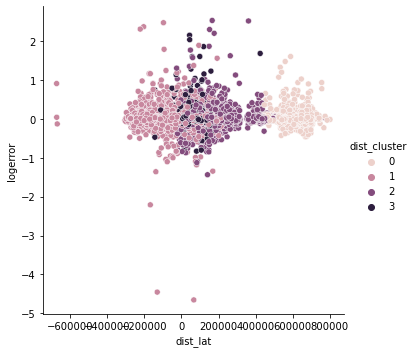

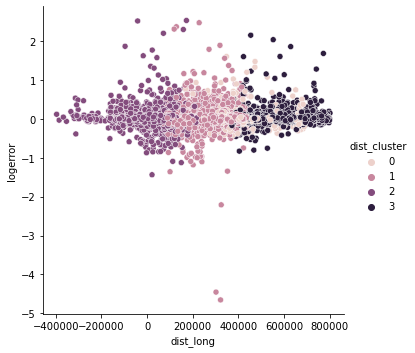

In [11]:
sns.relplot(data=train1, y='logerror', x='dist_lat', hue='dist_cluster')
sns.relplot(data=train1, y='logerror', x='dist_long', hue='dist_cluster')

plt.show()

---

# prep for lr modeling

In [17]:
lrmodel_train1_df = lr_model_prep(cluster_df1_train, train1)
lrmodel_val1_df = lr_model_prep(cluster_df1_val, validate1)
lrmodel_test1_df = lr_model_prep(cluster_df1_test, test1)

lrmodel_train2_df = lr_model_prep(cluster_df2_train, train2)
lrmodel_val2_df = lr_model_prep(cluster_df2_val, validate2)
lrmodel_test2_df = lr_model_prep(cluster_df2_test, test2)

lrmodel_train3_df = lr_model_prep(cluster_df3_train, train3)
lrmodel_val3_df = lr_model_prep(cluster_df3_val, validate3)
lrmodel_test3_df = lr_model_prep(cluster_df3_test, test3)


In [18]:
lrmodel_train1_df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,dist_lat,dist_long,bedbathsqft_cluster,latlong_cluster,dist_cluster,bedbathsqft_cluster_1,bedbathsqft_cluster_2,latlong_cluster_1,latlong_cluster_2,latlong_cluster_3,dist_cluster_1,dist_cluster_2,dist_cluster_3
54251,0.000000,0.333333,0.288449,0.393231,0.672171,0.393231,0.672171,1,1,1,1,0,1,0,0,1,0,0
66483,0.333333,0.333333,0.561264,0.546168,0.374471,0.546168,0.374471,0,2,2,0,0,0,1,0,0,1,0
8143,0.666667,1.000000,0.782068,0.867092,0.565272,0.867092,0.565272,2,0,0,0,1,0,0,0,0,0,0
40171,0.333333,0.333333,0.391193,0.322409,0.666569,0.322409,0.666569,0,1,1,0,0,1,0,0,1,0,0
37135,0.333333,0.000000,0.291640,0.554581,0.427608,0.554581,0.427608,1,2,2,1,0,0,1,0,0,1,0


In [19]:
lrmodel_train1_df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'dist_lat', 'dist_long', 'bedbathsqft_cluster',
       'latlong_cluster', 'dist_cluster', 'bedbathsqft_cluster_1',
       'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3', 'dist_cluster_1', 'dist_cluster_2',
       'dist_cluster_3'],
      dtype='object')

In [28]:
x_train_features = lrmodel_train1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_validate_features = validate1[['logerror']]

m1d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with median home price
m1d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m1d1_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_1(y_predicted):
    return mean_squared_error(m1d1_predictions.actual, y_predicted)

In [29]:
m1d1_predictions.head()

,actual,baseline,polynomial only interaction
55152,0.015561,0.01814,0.012608
62488,0.057417,0.01814,0.011724
75790,-0.085135,0.01814,0.011605
15812,-0.044745,0.01814,0.013094
50543,0.065564,0.01814,0.016413


In [23]:
x_train_features = lrmodel_train2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_validate_features = validate2[['logerror']]

m1d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with median home price
m1d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m1d2_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_2(y_predicted):
    return mean_squared_error(m1d2_predictions.actual, y_predicted)

In [24]:
m1d2_predictions.head()

,actual,baseline,polynomial only interaction
41935,-0.004037,0.019433,0.026021
47209,0.013073,0.019433,0.024763
3317,0.065052,0.019433,0.022283
51992,0.461837,0.019433,0.022551
41171,-0.000858,0.019433,0.026159


In [25]:
x_train_features = lrmodel_train3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_validate_features = validate3[['logerror']]

m1d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with median home price
m1d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m1d3_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_3(y_predicted):
    return mean_squared_error(m1d3_predictions.actual, y_predicted)

In [26]:
m1d3_predictions.head()

,actual,baseline,polynomial only interaction
49352,0.019276,0.010437,0.015890
28336,0.013968,0.010437,0.014013
64161,-0.015888,0.010437,0.012939
1520,0.018657,0.010437,0.020515
74359,-0.033779,0.010437,0.011361


In [34]:
print('Model 1 with the Los Angeles County, CA dataset:')
print('--------------------------------------------------')
print(m1d1_predictions.apply(calculate_mse_1).apply(math.sqrt))
print('==================================================')
print('')
print('Model 1 with the Orange County, CA dataset:')
print('--------------------------------------------------')
print(m1d2_predictions.apply(calculate_mse_2).apply(math.sqrt))
print('==================================================')
print('')
print('Model 1 with the Ventura County, CA dataset:')
print('--------------------------------------------------')
print(m1d3_predictions.apply(calculate_mse_3).apply(math.sqrt))
print('==================================================')

Model 1 with the Los Angeles County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.184332
polynomial only interaction    0.184344
dtype: float64

Model 2 with the Orange County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.173613
polynomial only interaction    0.173689
dtype: float64

Model 3 with the Ventura County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.139557
polynomial only interaction    0.139950
dtype: float64


---

In [46]:
x_train_features = lrmodel_train1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_validate_features = validate1[['logerror']]

m2d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with median home price
m2d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m2d1_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_4(y_predicted):
    return mean_squared_error(m2d1_predictions.actual, y_predicted)


In [47]:
m2d1_predictions.head()

,actual,baseline,polynomial only interaction
55152,0.015561,0.01814,0.020045
62488,0.057417,0.01814,0.014845
75790,-0.085135,0.01814,0.007161
15812,-0.044745,0.01814,0.003862
50543,0.065564,0.01814,0.012380


In [48]:
x_train_features = lrmodel_train2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_validate_features = validate2[['logerror']]

m2d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with median home price
m2d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m2d2_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_5(y_predicted):
    return mean_squared_error(m2d2_predictions.actual, y_predicted)


In [49]:
m2d2_predictions.head()

,actual,baseline,polynomial only interaction
41935,-0.004037,0.019433,0.010519
47209,0.013073,0.019433,0.041462
3317,0.065052,0.019433,0.017808
51992,0.461837,0.019433,0.023288
41171,-0.000858,0.019433,0.006383


In [50]:
x_train_features = lrmodel_train3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
y_validate_features = validate3[['logerror']]

m2d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with median home price
m2d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m2d3_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_6(y_predicted):
    return mean_squared_error(m2d3_predictions.actual, y_predicted)


In [51]:
m2d3_predictions.head()

,actual,baseline,polynomial only interaction
49352,0.019276,0.010437,0.006794
28336,0.013968,0.010437,0.013672
64161,-0.015888,0.010437,-0.000308
1520,0.018657,0.010437,0.023656
74359,-0.033779,0.010437,0.017256


In [52]:
print('Model 2 with the Los Angeles County, CA dataset:')
print('--------------------------------------------------')
print(m2d1_predictions.apply(calculate_mse_4).apply(math.sqrt))
print('==================================================')
print('')
print('Model 2 with the Orange County, CA dataset:')
print('--------------------------------------------------')
print(m2d2_predictions.apply(calculate_mse_5).apply(math.sqrt))
print('==================================================')
print('')
print('Model 2 with the Ventura County, CA dataset:')
print('--------------------------------------------------')
print(m2d3_predictions.apply(calculate_mse_6).apply(math.sqrt))
print('==================================================')

Model 2 with the Los Angeles County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.184332
polynomial only interaction    0.184408
dtype: float64

Model 2 with the Orange County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.173613
polynomial only interaction    0.173726
dtype: float64

Model 2 with the Ventura County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.139557
polynomial only interaction    0.140071
dtype: float64


---

In [62]:
x_train_features = lrmodel_train1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]

m3d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with median home price
m3d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m3d1_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_7(y_predicted):
    return mean_squared_error(m3d1_predictions.actual, y_predicted)
##########################
x_train_features = lrmodel_train2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]

m3d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with median home price
m3d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m3d2_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_8(y_predicted):
    return mean_squared_error(m3d2_predictions.actual, y_predicted)
###########################
x_train_features = lrmodel_train3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]

m3d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with median home price
m3d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m3d3_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_9(y_predicted):
    return mean_squared_error(m3d3_predictions.actual, y_predicted)



In [63]:
print('Model 3 with the Los Angeles County, CA dataset:')
print('--------------------------------------------------')
print(m3d1_predictions.apply(calculate_mse_7).apply(math.sqrt))
print('==================================================')
print('')
print('Model 3 with the Orange County, CA dataset:')
print('--------------------------------------------------')
print(m3d2_predictions.apply(calculate_mse_8).apply(math.sqrt))
print('==================================================')
print('')
print('Model 3 with the Ventura County, CA dataset:')
print('--------------------------------------------------')
print(m3d3_predictions.apply(calculate_mse_9).apply(math.sqrt))
print('==================================================')

Model 2 with the Los Angeles County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.184332
polynomial only interaction    0.184508
dtype: float64

Model 2 with the Orange County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.173613
polynomial only interaction    0.173854
dtype: float64

Model 2 with the Ventura County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.139557
polynomial only interaction    0.141661
dtype: float64


---

In [64]:
x_train_features = lrmodel_train1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]

m4d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with median home price
m4d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m4d1_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_10(y_predicted):
    return mean_squared_error(m4d1_predictions.actual, y_predicted)
##########################
x_train_features = lrmodel_train2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]

m4d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with median home price
m4d2_predictions['baseline'] = validate2.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m4d2_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_11(y_predicted):
    return mean_squared_error(m4d2_predictions.actual, y_predicted)
###########################
x_train_features = lrmodel_train3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]

m4d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with median home price
m4d3_predictions['baseline'] = validate3.logerror.mean()
#create the polynomial model object
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=True)
#fit the polynomial model object with the scaled x_train variables
poly.fit(x_train_features)
#create a dataframe with the results of fitting the polynomial object
x_train_poly = pd.DataFrame(
    poly.transform(x_train_features),
    columns=poly.get_feature_names(x_train_features.columns),
    index=x_train_features.index,
)
#create a linear regression model object
lm = LinearRegression()
#fit the linear regression model with the above created polynomial dataframe
lm.fit(x_train_poly, y_train_features)
#make predictions on the scaled validate data
x_validate_poly = poly.transform(x_validate_features)
#create a column in the predictions dataframe with the resulting model predictions
m4d3_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_12(y_predicted):
    return mean_squared_error(m4d3_predictions.actual, y_predicted)



In [65]:
print('Model 4 with the Los Angeles County, CA dataset:')
print('--------------------------------------------------')
print(m4d1_predictions.apply(calculate_mse_10).apply(math.sqrt))
print('==================================================')
print('')
print('Model 4 with the Orange County, CA dataset:')
print('--------------------------------------------------')
print(m4d2_predictions.apply(calculate_mse_11).apply(math.sqrt))
print('==================================================')
print('')
print('Model 4 with the Ventura County, CA dataset:')
print('--------------------------------------------------')
print(m4d3_predictions.apply(calculate_mse_12).apply(math.sqrt))
print('==================================================')

Model 4 with the Los Angeles County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.184332
polynomial only interaction    0.184780
dtype: float64

Model 4 with the Orange County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.173613
polynomial only interaction    0.173610
dtype: float64

Model 4 with the Ventura County, CA dataset:
--------------------------------------------------
actual                         0.000000
baseline                       0.139557
polynomial only interaction    0.139653
dtype: float64


<AxesSubplot:>

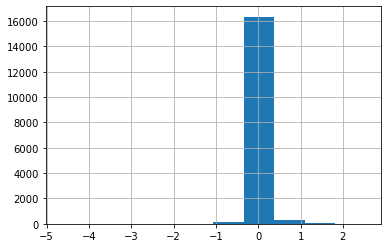

In [67]:
train1.logerror.hist()

In [69]:
x_train_features = lrmodel_train1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train1[['logerror']]
x_validate_features = lrmodel_val1_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate1[['logerror']]

m5d1_predictions = pd.DataFrame({'actual': validate1.logerror})
#add a baseline column to the predictions dataframe with median home price
m5d1_predictions['baseline'] = validate1.logerror.mean()
#create the polynomial model object

glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train_features, y_train_features)

m5d1_predictions['tweddie'] = glm.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_13(y_predicted):
    return mean_squared_error(m5d1_predictions.actual, y_predicted)
##########################
x_train_features = lrmodel_train2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train2[['logerror']]
x_validate_features = lrmodel_val2_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate2[['logerror']]

m5d2_predictions = pd.DataFrame({'actual': validate2.logerror})
#add a baseline column to the predictions dataframe with median home price
m5d2_predictions['baseline'] = validate2.logerror.mean()
  
glm = TweedieRegressor(power=1, alpha=0)    
glm.fit(x_train_features, y_train_features)    
    
m5d2_predictions['tweddie'] = glm.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_14(y_predicted):
    return mean_squared_error(m5d2_predictions.actual, y_predicted)
###########################
x_train_features = lrmodel_train3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_train_features = train3[['logerror']]
x_validate_features = lrmodel_val3_df[['bedbathsqft_cluster_1', 'bedbathsqft_cluster_2', 'latlong_cluster_1', 'latlong_cluster_2',
       'latlong_cluster_3']]
y_validate_features = validate3[['logerror']]

m5d3_predictions = pd.DataFrame({'actual': validate3.logerror})
#add a baseline column to the predictions dataframe with median home price
m5d3_predictions['baseline'] = validate3.logerror.mean()

glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train_features, y_train_features)



m5d3_predictions['polynomial only interaction'] = glm.predict(x_validate_features)
#calculate the mean squared error for the baseline and model predictions against the actual home prices
def calculate_mse_15(y_predicted):
    return mean_squared_error(m5d3_predictions.actual, y_predicted)



ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution